In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

save = True
pd.options.display.float_format = '{:,.2f}'.format

# Functions to read the performance metrics
- Read the data from the performance file and create a dataframe with the information
- Aggregate dataframes for each type of staging algorithm into one

In [3]:
def add_engine_results(file, engine="streaming"):
    results = []
    inf = open(file, "r")
    for line in inf:
        line = line.split("\n")[0]
        line = line.split(",")
        array = int(line[2]) * int(line[3])
        if line[1] == "Write":
            # add a new entry with write resutls and empty results for read
            results.append([line[0], 0, int(line[2]), array, int(line[4]), 0,
                            float(line[6]) / 1000000, 0, float(line[5]) / 1000000])
        if line[1] == "Read":
            if array != results[len(results)-1][3]:
                print("ERROR in matching reads and writes in file %s on line:\n %s" %(file, line))
            results[len(results)-1][1] = int(line[2])
            results[len(results)-1][5] = float(line[6]) / 1000000 # time in seconds
            results[len(results)-1][7] = float(line[5]) / 1000000
    inf.close()
    df = pd.DataFrame(results,columns=["Engine", "ReadCores", "WriteCores", "TotalArraySize",
                                       "Variables", "ReadTime", "WriteTime", "GetTime", "PutTime"])
    df["TotalFileSize"] = df["TotalArraySize"] * df["Variables"] * 4 / (1024 * 1024 * 1024) # Measure in GB
    df["ReadSize"] = df["TotalFileSize"] / df["ReadCores"]
    df["WriteSize"] = df["TotalFileSize"] / df["WriteCores"]
    if engine=="file":
        df['TotalTime'] = df['WriteTime'] + df['ReadTime']
        df['Delay'] = df['WriteTime']
    else:
        df['TotalTime'] = df[['WriteTime', 'ReadTime']].values.max(1)
        df["Delay"] = df["PutTime"]# - df["GetTime"]
    return df

In [13]:
def read_data(test_name, extension):
    df = pd.concat([add_engine_results("results/%s.ssc%s" %(test_name, extension)),
                add_engine_results("results/%s.sst%s" %(test_name, extension)),
                add_engine_results("results/%s.bp%s" %(test_name, extension), engine="file")])
    return df

# Functions to plot the performance data
- Line plot for aggregation figures
- Bar plot for each experiment individually

In [4]:
def plot(data, x="Procs", y="Time", hue=-1, log=False, save=False):
    sns.set(font_scale=2)
    sns.set_style("whitegrid")
    colors = ["#422451", '#428fa4', "orange", "#74687a"]
    sns.set_palette(sns.color_palette(colors))
    fig, ax = plt.subplots(figsize=(10,8))
    if hue == -1:
        ax = sns.lineplot(x=x, y=y, data=data)
    else:
        ax = sns.lineplot(x=x, y=y, data=data, hue=hue)
    if log:
        ax.set(yscale="log")
    if save:
        plt.savefig(save, bbox_inches = 'tight')
    plt.show()
    return ax

In [33]:
def barplot(df, column, test_name, xlabel=False, test_ticks=[],
            test_labels=[], ylim=-1, log=False, extension=""):
    sns.set(font_scale=2)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(10,10))

    colors = ["#a796ae", '#b8d1d9', "#ffe79e", "#b39ea3"]
    labels=["SSC", "SST", "BP"]
    sns.set_palette(sns.color_palette(colors))
    ax = sns.barplot(x=column, y="TotalTime", data=df,
                hue='Engine', hue_order=labels)

    colors = ["#422451", '#428fa4', "orange", "#74687a"]
    sns.set_palette(sns.color_palette(colors))
    ax = sns.barplot(x=column, y="Delay", data=df,
                     hue='Engine', hue_order=labels)
    for bar in ax.patches:
        width = bar.get_width()
        bar.set_width(9 * width / 10)

    if ylim > 0 and not log:
        ax.set_ylim([0, ylim])
    if len(test_ticks) > 0:
        ax.set_xticklabels(test_ticks, rotation=20)
    if len(test_labels) > 0:
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, test_labels, ncol = 2)
    else:
        ax.legend(ncol = 2)

    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel("Time [seconds]")

    if log:
        ax.set(yscale="log")
    sns.despine(left = True, bottom = True)
    plt.savefig("figures/%s%s.png" %(test_name, extension), bbox_inches = 'tight')
    plt.show()

# Plot the results for each individual scenario

- Scaling (strong and weak)
- Parameter imact

## 1. Weak scaling
    - Data size is constant per Writer
    - Number of writers (`WR = 32, 64, 128, 256, 512, 1024`) and readers `RD = WR / 2`
    - Weak scaling by keeping the data per writer fixed, total amount of data increases with WR 
```
$ du -h output_file*
2.8T	output_file128
5.6T	output_file256
716G	output_file32
1.4T	output_file64
23T	output_file1024
12T	output_file512
```

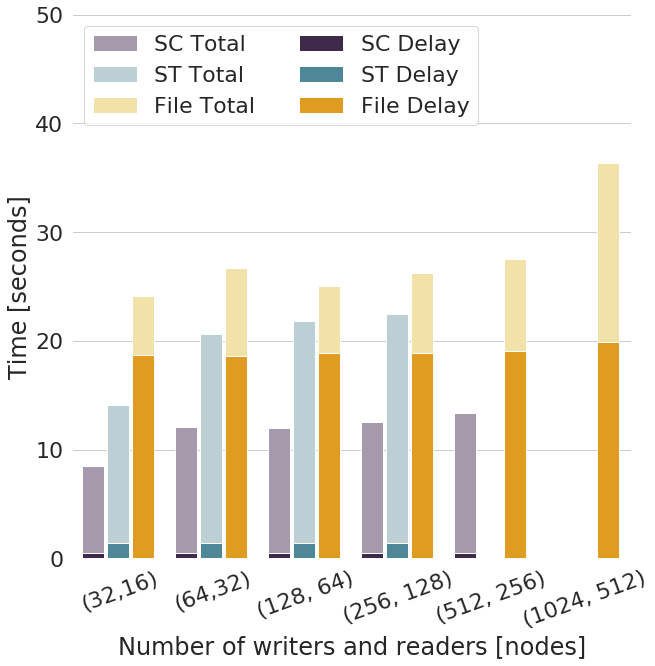

,Engine,ReadCores,WriteCores,TotalArraySize,Variables,ReadTime,WriteTime,GetTime,PutTime,TotalFileSize,ReadSize,WriteSize,TotalTime,Delay
0,SSC,384,768,192000000000,1,8.49,8.49,0.00,0.52,715.26,1.86,0.93,8.49,0.52
1,SSC,768,1536,384000000000,1,12.04,12.04,0.00,0.53,"1,430.51",1.86,0.93,12.04,0.53
2,SSC,1536,3072,768000000000,1,11.94,11.94,0.00,0.53,"2,861.02",1.86,0.93,11.94,0.53
3,SSC,3072,6144,1536000000000,1,12.56,12.56,0.00,0.53,"5,722.05",1.86,0.93,12.56,0.53
4,SSC,6144,12288,3072000000000,1,13.39,13.39,0.00,0.53,"11,444.09",1.86,0.93,13.39,0.53


In [15]:
test_name = "strong"
extension = ""
test_column= "WriteCores"
df = read_data(test_name, extension)

# test_ticks = ["(768,384)","(1536,768)","(3072, 1536)",
#               "(6144, 3072)","(12288, 6144)", "(24576, 12288)"]
test_labels = ["SC Total","ST Total", "File Total","SC Delay","ST Delay","File Delay"]
test_ticks = ["(32,16)","(64,32)","(128, 64)",
               "(256, 128)","(512, 256)", "(1024, 512)"]
barplot(df, test_column, test_name, xlabel="Number of writers and readers [nodes]",
        test_ticks=test_ticks, test_labels=test_labels, ylim=50, log=False, extension=extension)

df.head()

## 2. Strong scaling
    - Total amount of exchanged data size is constant 
    - Number of writers (`WR = 32, 64, 128, 256, 512, 1024`) and readers `RD = WR / 2`
    - Strong scaling by keeping the same amount of total data (D) and data per writer (D/WR), per reader (D/RD) 
```
$ du -h output_file*
94G	output_file128
94G	output_file256
94G	output_file32
94G	output_file64
94G	output_file1024
94G	output_file512
```

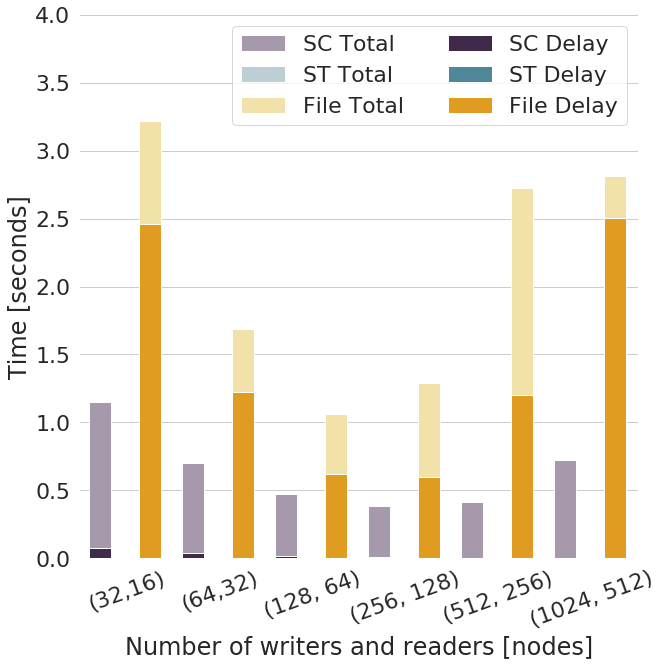

,Engine,ReadCores,WriteCores,TotalArraySize,Variables,ReadTime,WriteTime,GetTime,PutTime,TotalFileSize,ReadSize,WriteSize,TotalTime,Delay
0,SSC,384,768,24999999744,1,1.15,1.15,0.00,0.07,93.13,0.24,0.12,1.15,0.07
1,SSC,768,1536,24999998976,1,0.70,0.70,0.00,0.04,93.13,0.12,0.06,0.70,0.04
2,SSC,1536,3072,24999997440,1,0.47,0.47,0.00,0.02,93.13,0.06,0.03,0.47,0.02
3,SSC,3072,6144,24999997440,1,0.38,0.38,0.00,0.01,93.13,0.03,0.02,0.38,0.01
4,SSC,6144,12288,24999997440,1,0.41,0.40,0.00,0.00,93.13,0.02,0.01,0.41,0.00


In [19]:
test_name = "weak"
extension = ".100G"
test_column= "WriteCores"
df = read_data(test_name, extension)

# test_ticks = ["(768,384)","(1536,768)","(3072, 1536)",
#               "(6144, 3072)","(12288, 6144)", "(24576, 12288)"]
test_labels = ["SC Total","ST Total", "File Total","SC Delay","ST Delay","File Delay"]
test_ticks = ["(32,16)","(64,32)","(128, 64)",
               "(256, 128)","(512, 256)", "(1024, 512)"]
barplot(df, test_column, test_name, xlabel="Number of writers and readers [nodes]",
        test_ticks=test_ticks, test_labels=test_labels, ylim=4, log=False, extension=extension)

df.head()

## 3. Parameter impact

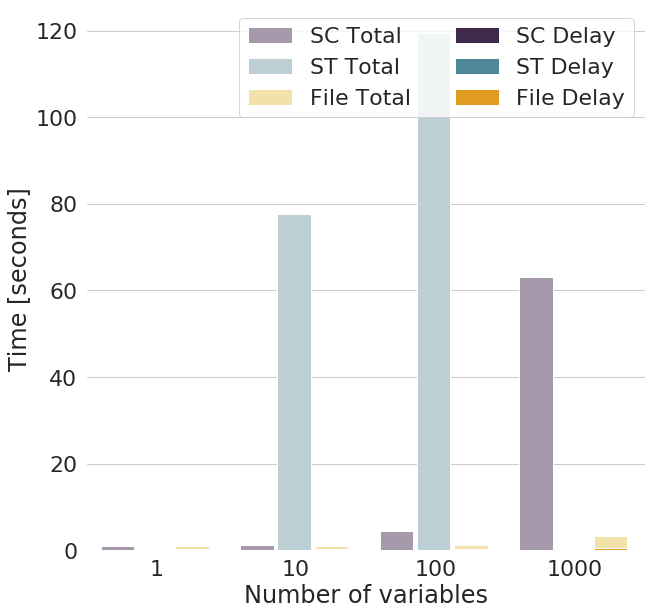

,Engine,ReadCores,WriteCores,TotalArraySize,Variables,ReadTime,WriteTime,GetTime,PutTime,TotalFileSize,ReadSize,WriteSize,TotalTime,Delay
0,SSC,240,2400,12288000000,1,1.09,1.09,0.00,0.01,45.78,0.19,0.02,1.09,0.01
1,SSC,240,2400,1228800000,10,1.33,1.33,0.00,0.02,45.78,0.19,0.02,1.33,0.02
2,SSC,240,2400,122880000,100,4.53,4.52,0.00,0.02,45.78,0.19,0.02,4.53,0.02
3,SSC,240,2400,12288000,1000,63.03,63.02,0.01,0.02,45.78,0.19,0.02,63.03,0.02
0,SST,240,2400,1228800000,10,77.74,0.09,0.02,0.05,45.78,0.19,0.02,77.74,0.05


In [34]:
test_name = "variable"
extension = ".w100.r10.v45G"
test_column= "Variables"
df = read_data(test_name, extension)

# test_ticks = ["(768,384)","(1536,768)","(3072, 1536)",
#               "(6144, 3072)","(12288, 6144)", "(24576, 12288)"]
test_labels = ["SC Total","ST Total", "File Total","SC Delay","ST Delay","File Delay"]
test_ticks = []
barplot(df, test_column, test_name, xlabel="Number of variables",
        test_labels=test_labels, log=False, extension=extension)

df.head()

# Aggregated figures

In [32]:
def read_perf(file):
    df = pd.read_csv(file, delimiter=",", names=["Engine", "IOType", "Procs", "N", "Variables",
                                                 "OPTime", "Time"])
    df["Time"] = df["Time"] / 1000 # convert to seconds
    # Operation time (time spent until application gets control back from ADIOS after a get / put)
    df["OPTime"] = df["OPTime"] / 1000 # convert to seconds
    # Convert array size from number of floats to MB
    df["FileSize"] = df["N"] * 4 / (1024 * 1024) # measure in MB
    df["Delay"] = df["Time"] - df["OPTime"]
    # total size read / written by each process
    df["TotalSize"] = (df["FileSize"] * df["Variables"]) / 1024 # measure in GB
    # total size in transit (or saved on disk for BP)
    df["DiskSize"] = df["TotalSize"] * df["Procs"] # in GB
    df["SizePerVariable"] = df["N"] * df["Procs"] 
    return df
df = pd.concat([add_engine_results("results.streaming"),
                add_engine_results("results.file", engine="file")])

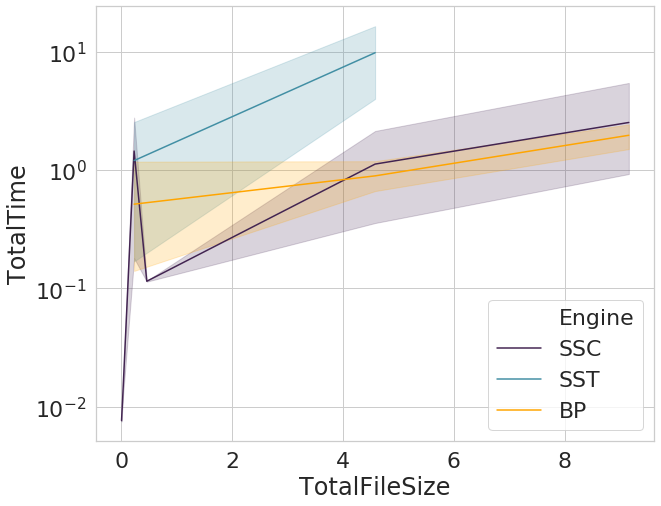

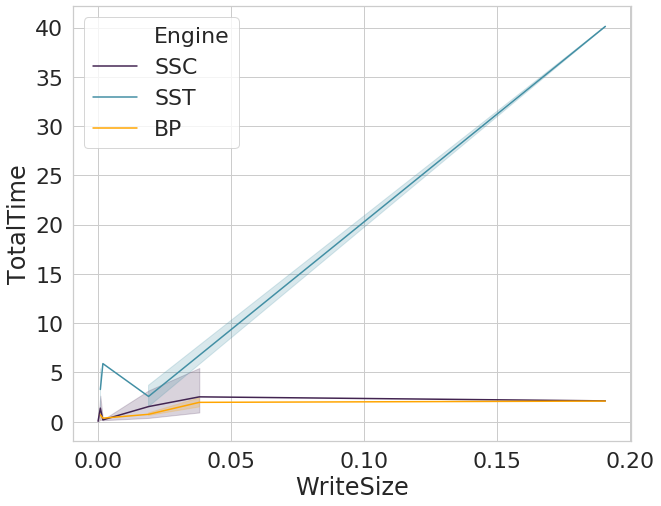

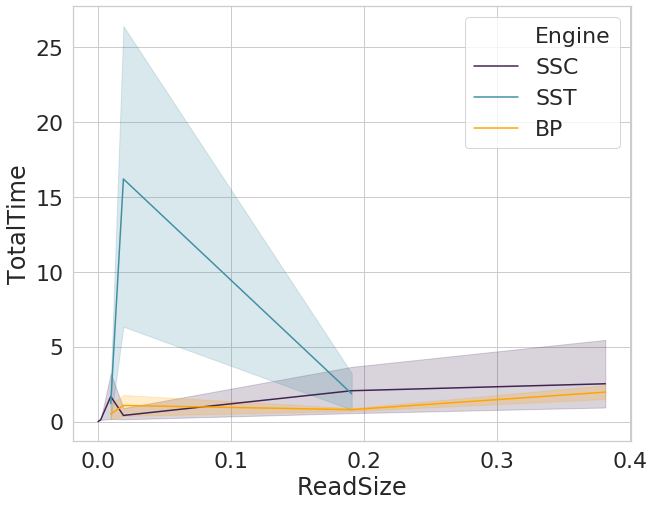

In [36]:
plot(df, x="TotalFileSize", y="TotalTime", hue="Engine", log=True)
plot(df, x="WriteSize", y="TotalTime", hue="Engine")
plot(df, x="ReadSize", y="TotalTime", hue="Engine")